# Libraries

In [64]:
# Basics
import pandas as pd
import numpy as np
import os
from pathlib import Path
from jupyterthemes import jtplot
jtplot.style(theme='monokai')
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime  
from datetime import timedelta 
import pickle

# PLotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Scipy
from scipy import stats

# Tensorflow keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

# Scikit-learn
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing, metrics
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_regression, SelectFromModel
from sklearn.linear_model import LinearRegression, LogisticRegression, BayesianRidge, LassoLars
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller # ADF, check for seasonality of data
from statsmodels.tsa.ar_model import AutoReg # Residual Analysis

# Load Data

In [65]:
# Load data
def load_stock_data(ticker, interval):
    """
    This function load stock data from Database files by first changing the working directory, loading the data and reset the working directory to the original path
    
    Parameters
    ----------
    ticker : str
        a string that describes the stock ticker, as listed in the file name
    interval : str
        an interval string according to the existing files in the databases
    """
    # Record original working directory
    owd = os.getcwd()
    # Change directory
    os.chdir('C:\\Users\\asus\\Documents\\Python Projects\\Trading - Research and Backtest\\'+ticker+'\\Databases\\')
    datapath = os.getcwd()+'\\'
    # Record all available files
    files = []
    for (dirpath, dirname, filenames) in os.walk(datapath):
        files.extend(filenames)
        break
    # Import as dataframe  
    df = pd.read_csv(datapath+ticker+'-'+interval+'.csv', parse_dates=True, index_col='Datetime')
    # Return working directory to original
    os.chdir(owd)
    return df
interval = '5min' # Choose interval
df_aapl = load_stock_data('AAPL', interval=interval)
df_spy = load_stock_data('SPY', interval=interval)

In [66]:
# Merge Data
start_date = '2020-08-25'
start_time = '09:30'
end_time = '16:00'
df = pd.merge(df_aapl.between_time(start_time, end_time).loc[start_date:].drop(columns=['Close', 'Dividends', 'Stock Splits']),
                    df_spy.between_time(start_time, end_time).loc[start_date:].drop(columns=['Close', 'Dividends', 'Stock Splits']),
                    left_index=True, right_index=True
                    )
df.rename(columns={'Open_x': 'Open_AAPL', 'High_x': 'High_AAPL', 'Low_x': 'Low_AAPL', 'Adj Close_x': 'Close_AAPL', 
                         'Volume_x': 'Volume_AAPL', 'Open_y': 'Open_SPY', 'High_y': 'High_SPY', 'Low_y': 'Low_SPY', 
                         'Adj Close_y': 'Close_SPY', 'Volume_y': 'Volume_SPY'}, inplace=True)

In [100]:
# Load Variables
def load_variables(filename=None):
    with open(filename, 'rb') as f:
        variables = pickle.load(f)
    return variables
variables = load_variables('AAPL-5min.pickle')

# Data Manipulation

## Seasonal Decomposing

In [68]:
def Seasonality_check(time_series, alpha = 0.05):
    '''
    Pass a time series, return an ADF report on data seasonality
    H0: data is non-seasonal, default alpha = 0.05
    Accept H0 if p-value > alpha
    '''
    result = adfuller(time_series)
    return result[1] <= alpha

In [69]:
def runsTest(l, l_median, Zcritical=1.96): 
    runs, n1, n2 = 0, 0, 0
    # Checking for start of new run 
    for i in range(len(l)): 
        # no. of runs 
        if (l[i] >= l_median and l[i-1] < l_median) or (l[i] < l_median and l[i-1] >= l_median): 
            runs += 1
        # no. of positive values 
        if(l[i]) >= l_median: 
            n1 += 1
        # no. of negative values 
        else: 
            n2 += 1
    runs_exp = ((2*n1*n2)/(n1+n2))+1
    stan_dev = np.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/ \
                (((n1+n2)**2)*(n1+n2-1)))
    z = (runs-runs_exp)/stan_dev
    # Data is not random if |Z| > Zcritical
    return abs(z) > Zcritical

In [70]:
# Decompose Data
freq = variables['lag_freq'] # 120 minutes
for column in df.columns:
    if 'Volume' not in column:
        TS_decompose = seasonal_decompose(df[column], model='additive', freq = freq, two_sided=False)
        delta_trend = (TS_decompose.trend.dropna() - TS_decompose.trend.dropna().shift(1)).dropna()
        delta_seasonal = ((TS_decompose.seasonal - TS_decompose.seasonal.shift(1)).loc[delta_trend.index[0]:])
        delta_resid = ((TS_decompose.resid - TS_decompose.resid.shift(1)).loc[delta_trend.index[0]:])
        predictor = delta_trend + delta_seasonal
        # Check seasonality
        if Seasonality_check(predictor):
            # Check Randomness
            if runsTest(predictor, predictor.median()):
                # Add to DataFrame
                df[column+'_decomp'] = predictor
                df[column+'_trend'] = TS_decompose.trend
                df[column+'_season'] = TS_decompose.seasonal
                df[column+'_resid'] = TS_decompose.resid
            else:
                print(column, ' is random')
        else:
            print(column, ' is not stationary')
    else:
        TS_decompose = seasonal_decompose(df[column], model='additive', freq = freq, two_sided=False)
        delta_trend = (TS_decompose.trend.dropna() / TS_decompose.trend.dropna().shift(1)).dropna()
        delta_seasonal = ((TS_decompose.seasonal / TS_decompose.seasonal.shift(1)).loc[delta_trend.index[0]:])
        delta_resid = ((TS_decompose.resid / TS_decompose.resid.shift(1)).loc[delta_trend.index[0]:])
        predictor = delta_trend + delta_seasonal
        # Check seasonality
        if Seasonality_check(predictor):
            # Check Randomness
            if runsTest(predictor, predictor.median()):
                # Add to DataFrame
                df[column+'_decomp'] = predictor
                df[column+'_trend'] = TS_decompose.trend
                df[column+'_season'] = TS_decompose.seasonal
                df[column+'_resid'] = TS_decompose.resid
            else:
                print(column, ' is random')
        else:
            print(column, ' is not stationary')
df.dropna(inplace=True)

Volume_SPY  is random


## Shift Data

In [71]:
# Shift Data
df_target = df[['Close_AAPL_decomp']].iloc[1:, :] # Target Data is not shifted
target_signal = ['Close_AAPL_decomp_y']
df_target.columns = target_signal
print('Target Data ',len(df_target), '\n', tabulate(df_target.head(), headers='keys'))
print('\n')
# Shift Features Data:
# Shift everything except Opening Price
# Create Function to remove certain columns from being shifted
def shift_exception(df, col_exception = ['Open']):
    df_columns = df.columns.to_list()
    def fil_col(col_name):
        exception = col_exception
        for n_exception in range(len(exception)):
            if (exception[n_exception] in col_name):
                return True
    
    list_exception = list(filter(fil_col, df_columns)) 
    return list_exception
_df = df.copy()
exception = shift_exception(df, col_exception = ['Open'])
_df.loc[:, df.drop(columns=exception).columns] = _df.loc[:,df.drop(columns=exception).columns].shift(1)
# Drop Target Data
df_features = _df.dropna()
df_features = df_features[df_features.filter(like='decomp').columns]
del _df
print('Features Data ',len(df_features))

Target Data  918 
 Datetime               Close_AAPL_decomp_y
-------------------  ---------------------
2020-08-25 11:40:00            0.0857906
2020-08-25 11:45:00           -0.0453152
2020-08-25 11:50:00            0.029375
2020-08-25 11:55:00           -4.80769e-05
2020-08-25 12:00:00           -0.203723


Features Data  918


In [72]:
# Concat df_features and df_target into df_concat
df_concat = pd.concat([df_features, df_target], axis=1)
print('df_concat', len(df_concat), '\n')

df_concat 918 



## Select Feature

In [101]:
# Features
features = variables['Features']

In [74]:
# Target Data
df_target = df_concat[target_signal]
# Features Data
df_features = df_concat[features]

In [75]:
# Convert to Numpy Arrays
# Features Data
x_data = df_features.values
print('Features Data to array ', type(x_data), x_data.shape)
# Target Data
y_data = df_target[target_signal].values
print('Target Data to array ', type(y_data), y_data.shape)

Features Data to array  <class 'numpy.ndarray'> (918, 3)
Target Data to array  <class 'numpy.ndarray'> (918, 1)


In [76]:
# Train-test split
train_split = 0.7
num_data = len(x_data)
num_train = int(train_split * num_data)
print('Number of observations in the training set: ', num_train, 'data-points')
num_test = num_data - num_train
print('Number of observations in the testing set: ', num_test, 'data-points')
# Split data
# Features Data
num_x_signals = x_data.shape[1]
print('Total Features: ', num_x_signals, 'features')
x_train = x_data[:num_train]
x_test = x_data[num_train:]
if len(x_train) + len(x_test) == num_data:
    print('Features Data Split Done')
    pass
# Target Data
num_y_signals = y_data.shape[1]
print('Total Target: ', num_y_signals, 'target')
y_train = y_data[:num_train]
y_test = y_data[num_train:]
if len(y_train) + len(y_test) == num_data:
    print('Target Data Split Done')
    pass

Number of observations in the training set:  642 data-points
Number of observations in the testing set:  276 data-points
Total Features:  3 features
Features Data Split Done
Total Target:  1 target
Target Data Split Done


# Scale Data

In [77]:
# Scaler for input data
x_scaler = variables['x_scaler']
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.fit_transform(x_test)

In [78]:
# Scaler for output data
y_scaler = variables['y_scaler']
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.fit_transform(y_test)

# Load Model

In [79]:
model = load_model('RNN_AAPL-5min.h5')

# Predict Future

Predict Future

## Data Manipulation

In [80]:
# Data Manipulation for future prediction
# Get shifted Data
shifted_data = pd.DataFrame(df.iloc[-1, :][features]).T# Since all features are shifted data so there is need to further process this
# Fix Future Dating
if df_features.index.name == 'Datetime':
    _ = df_features.index[-1] + timedelta(minutes=5)
elif df_features.index.name == 'Date':
    for x in np.arange(5, 75, step=15, dtype=int):
        # Add days to the last day
        x = x.item()
        _ = df_features.index[-1] + timedelta(minutes=x)
        if _.weekday() < 5: # Repeat until it's working Monday-Friday
            break    
shifted_data.index = [_] # Add as index
del _
# Add future features
df_features_future = df_features.append(shifted_data)
print(tabulate(df_features_future.tail(), headers='keys'))

                       Open_AAPL_decomp    Volume_AAPL_decomp    Open_SPY_decomp
-------------------  ------------------  --------------------  -----------------
2020-09-10 15:45:00          -0.127591             -50.8807           -0.0987553
2020-09-10 15:50:00          -0.031015               0.649984         -0.132318
2020-09-10 15:55:00          -0.0879968             -0.261232         -0.245983
2020-09-10 16:00:00          -0.181127               3.56371          -0.177318
2020-09-10 16:05:00          -0.181127               0.917424         -0.177318


## Prediction

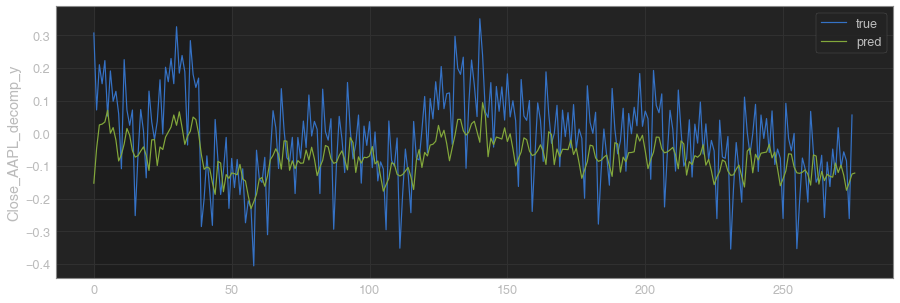

In [81]:
# Prediction
warmup_steps= 50
# Prediction
def predict_future(df_features_future=df_features_future,
                   start_idx=0,
                   length=100,
                   num_test=num_test):
    x_test_scaled = x_scaler.transform(
        df_features_future.iloc[-(num_test + 1):, :])
    x = x_test_scaled
    y_true = y_test
    # End-index for the sequences.
    end_idx = start_idx + length
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)
    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    # For each output-signal.
    for signal in range(len(target_signal)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]
        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15, 5))
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        # Plot labels etc.
        plt.ylabel(target_signal[signal])
        plt.legend()
        plt.show()
        return y_true, y_pred_rescaled
true_future, predict_future = predict_future(df_features_future=df_features_future, start_idx=0, length=1000)

In [82]:
# Compile Results
df_result_future = pd.DataFrame([true_future[:, 0], predict_future[:, 0]],
                                index=['True', 'Predictions']).T

In [83]:
# Write Function to find nearest value
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

In [84]:
# Find the optimal constant to adjust the return
_constant = []
for x in np.arange(0.8, 1.2, step=0.0001):
    adj_return = df_result_future['Predictions'][:-1] * x
    _diff = df_result_future['True'][:-1] - adj_return
    _constant.append((x, _diff[:-1].std()))
_constant = pd.DataFrame(_constant)
idx_constant, nearest_value = find_nearest(_constant[1], 0)
constant = _constant[0][idx_constant]
df_result_future['Predictions'] = df_result_future['Predictions'] * constant
df_result_future['Difference'] = df_result_future['True'] - df_result_future['Predictions']

In [85]:
# Create a model for residual errors
window = freq
train_resid = df['Close_AAPL_resid'][:num_train]
test_resid = df['Close_AAPL_resid'][num_train:]
model_residual = AutoReg(train_resid, lags=window)
model_fit = model_residual.fit()
coef = model_fit.params
# Walk Forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
expected_error = list()
for t in range(len(test_resid)+2):
    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    predictions.append(pred_error)
    if t < len(test_resid):
        history.append(df['Close_AAPL_resid'][num_train+t])
    else:
        history.append(pred_error)

In [86]:
# Convert to Price
price_pred = []
for i in range(num_test+1):
    price = df_result_future['Predictions'][i] + df['Close_AAPL'].iloc[-(num_test - i + 1)] - df['Close_AAPL_resid'].iloc[-(num_test - i + 1)] +\
            predictions[1:][i+1]
    price_pred.append(price)
df_result_future.index = df_features_future.iloc[-(num_test+1):].index
df_result_future['Price_True'] = np.append(df['Close_AAPL'].iloc[-(num_test):].values, 0)
df_result_future['Price_Predictions'] = price_pred
df_result_future['Price_Diff'] = np.abs(df_result_future['Price_True'] - df_result_future['Price_Predictions'])
print('df_result', '\n')
print(tabulate(df_result_future.describe(), headers='keys'))

df_result 

               True    Predictions     Difference    Price_True    Price_Predictions     Price_Diff
-----  ------------  -------------  -------------  ------------  -------------------  -------------
count  276             277          276               277                  277        277
mean    -0.0102431      -0.0845093    0.0740431       116.533              116.87       0.60663
std      0.136272        0.0664232    0.111339          7.28891              1.85949    6.82141
min     -0.406015       -0.27691     -0.208218          0                  112.648      0.000449622
25%     -0.0897731      -0.134379     0.000858435     116.02               116.004      0.0733246
50%     -0.00138158     -0.0858376    0.0711178       117.01               116.911      0.150232
75%      0.0714899      -0.041274     0.147703        118                  117.87       0.279562
max      0.351042        0.112885     0.490607        122.45               122.043    113.693


In [87]:
# Find the optimal constant to adjust prediction
_constant = []
for x in np.arange(0.8, 1.2000, step=0.0001):
    adj_price = df_result_future['Price_Predictions'][:-1] * x
    _diff = df_result_future['Price_True'][:-1] - adj_price
    _constant.append((x, _diff[:-1].mean()))
_constant = pd.DataFrame(_constant)
# Add the adjusted Price_Predictions to the df_result_future
idx_constant, nearest_value = find_nearest(_constant[1], 0)
constant = _constant[0][idx_constant]
df_result_future['Price_Predictions'] = df_result_future['Price_Predictions'] * constant
df_result_future['Price_Diff'] = df_result_future['Price_True'] - df_result_future['Price_Predictions']
print('df_result_future', '\n')
print(tabulate(df_result_future.iloc[:-1, :].describe(), headers='keys'))

df_result_future 

               True    Predictions     Difference    Price_True    Price_Predictions     Price_Diff
-----  ------------  -------------  -------------  ------------  -------------------  -------------
count  276             276          276               276                  276        276
mean    -0.0102431      -0.0842862    0.0740431       116.955              116.952      0.00387293
std      0.136272        0.0664398    0.111339          1.93925              1.85407    0.248386
min     -0.406015       -0.27691     -0.208218        112.67               112.716     -0.976668
25%     -0.0897731      -0.132763     0.000858435     116.035              116.081     -0.144254
50%     -0.00138158     -0.0846612    0.0711178       117.035              116.984     -0.000998943
75%      0.0714899      -0.0411093    0.147703        118.002              117.943      0.14713
max      0.351042        0.112885     0.490607        122.45               122.117      0.709495


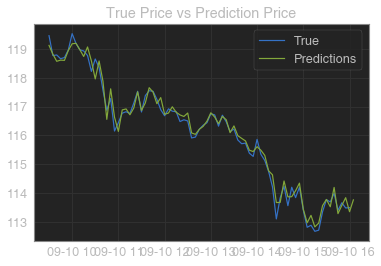

In [92]:
# Plot Price Prediction 
plt.plot(df_result_future['Price_True'].iloc[:-1,][-79:], label='True')
plt.plot(df_result_future['Price_Predictions'][-80:], label='Predictions')
plt.title('True Price vs Prediction Price')
plt.legend()
plt.show()

# Prediction

In [89]:
# Statement
truth = df_result_future['Price_True'].iloc[:-1].diff(freq).dropna()
predicted = df_result_future['Price_Predictions'].iloc[:-1].diff(freq).dropna()
print('Predictor Feature: ' + ', '.join(features))
print('One Step Ahead result is', df_result_future['Price_Predictions'][-1])
# Prediction R2 score
r2 = round(r2_score(truth, predicted) * 100, 2)
print('R2 score Price Prediction: ', r2, '%')

Predictor Feature: Open_AAPL_decomp, Volume_AAPL_decomp, Open_SPY_decomp
One Step Ahead result is 113.76147320986006
R2 score Price Prediction:  97.97 %
